In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from ccdproc import trim_image
from astropy import units as u

from specutils import Spectrum1D

# need to get import to work in notebook w/o global package install
import sys  
sys.path.append('..')

from apextract import trace, extract
from fluxcal import standard_sensfunc, apply_sensfunc, onedstd, obs_extinction, AirmassCor

In [2]:
fcal = '../../pydis_example/apo05/05may31.0020r.fits' # Flux std star observation

img = CCDData.read(fcal, unit=u.adu)
# put in units of ADU/s
img.data = img.data / (img.header['EXPTIME'])
img.unit = u.adu / u.s

# trim off bias section
img = trim_image(img, fits_section=img.header['DATASEC'])


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<ErrorbarContainer object of 3 artists>

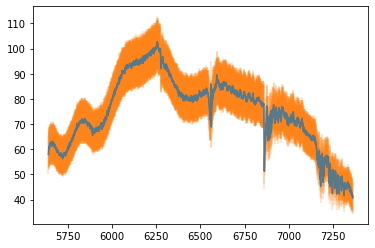

In [3]:
# Trace & Extract the standard star spectrum. See the extract example demo for more details
tr = trace(img, display=False, nbins=25)

flux_std, sky_std, ferr_std = extract(img, tr, display=False, 
                                      apwidth=8, skysep=3, skywidth=7)

# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(img.shape[1]) - img.shape[1]/2)[::-1] * img.header['DISPDW'] + img.header['DISPWC']

wapprox = wapprox * u.angstrom
obj_flux = (flux_std - sky_std) * u.adu / u.s

plt.plot(wapprox, obj_flux)
plt.errorbar(wapprox.value, flux_std - sky_std, yerr=ferr_std, alpha=0.25)

In [4]:
stdstar=onedstd('spec50cal/bd284211.dat')

stdstar

wave,mag,width,flux
Angstrom,mag,Angstrom,erg / (Angstrom cm2 s)
float64,float64,float64,float64
3200.0,9.63,50.0,1.494585437147621e-12
3250.0,9.58,50.0,1.517238942133151e-12
3300.0,9.56,50.0,1.498969593050037e-12
3350.0,9.57,50.0,1.4412226833675205e-12
3400.0,9.6,50.0,1.3610148657873372e-12
3450.0,9.64,50.0,1.2740383847001297e-12
3500.0,9.67,50.0,1.2041611578377217e-12
3550.0,9.68,50.0,1.159748973561773e-12


In [5]:
obj_spectrum = Spectrum1D(spectral_axis=wapprox, flux=obj_flux)

In [6]:
stdstar['flux'].unit / obj_spectrum.flux.unit

Unit("erg / (adu Angstrom cm2)")

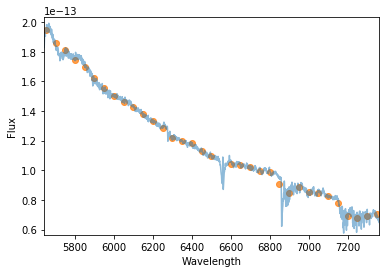

In [7]:
sensfunc_lin = standard_sensfunc(obj_spectrum, stdstar, display=True, mode='linear')

Though it's more noisy, the linear interpolation looks better in the observed x sensfunc curve in this case. I'd probably go with the linear here, and for quick-look scenarios. I personally don't like the polynomial case usually (not shown).

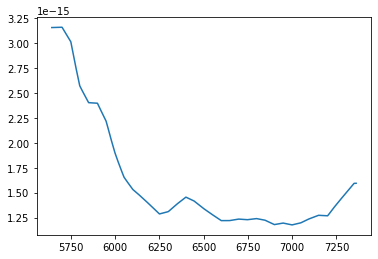

In [8]:
# the actual sensitivity function(s), which in theory include some crude information about 
# the flat fielding (response) - though the reference spectrum is very coarse.
plt.plot(wapprox, sensfunc_lin)

In [9]:
sensfunc_lin

<Quantity [1.59400383e-15, 1.59400383e-15, 1.59400383e-15, ...,
           3.15522469e-15, 3.15522469e-15, 3.15522469e-15] erg / (adu Angstrom cm2)>

(0, 3e-13)

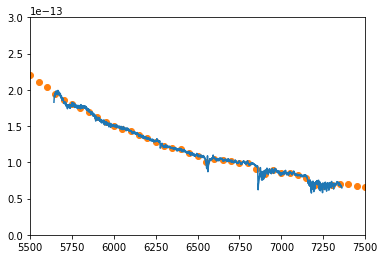

In [10]:
# now apply the sensfunc back to the std star to demonstrate
plt.plot(wapprox, obj_flux * sensfunc_lin)
plt.scatter(stdstar['wave'], stdstar['flux'], c='C1')
plt.xlim(5500,7500)
plt.ylim(0, 0.3e-12)

In [11]:
# and the result now has the right units!
(obj_flux * sensfunc_lin).unit

Unit("erg / (Angstrom cm2 s)")

In [12]:
Xfile = obs_extinction('apoextinct.dat')

In [13]:
AIRVAL = 1.2 # some made up airmass

Atest = AirmassCor(obj_spectrum, AIRVAL, Xfile)

In [16]:
obj_spectrum.multiply(obj_spectrum.flux, 10)

ValueError: Flux must be a `Quantity` object.